# Chatper 3: Classification

In [1]:
import numpy as np
import os
import src.chapter3 as ch3
np.random.seed(42)
%load_ext autoreload
%autoreload 2

# To plot pretty figures (copied and pasted from A.Geron's notebook)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

We read the MNIST data and reorder them as in the first edition of the book by using the `sort_by_train` function in the `chapter3` module.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.uint8)
ch3.sort_by_train(mnist)

In [4]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

Are these images already normalized? Let's find out:

In [6]:
X[1234].min(), X[1234].max(), X[1234].mean()

(0.0, 255.0, 40.89413265306123)

No, they are clearly not.

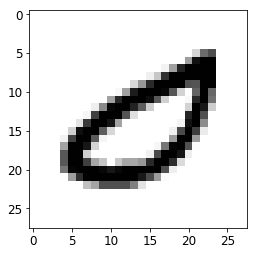

In [7]:
plt.imshow(X[1234].reshape(28, 28), cmap=mpl.cm.binary, interpolation='nearest')

If we plot all the 70,000 images (and play with the aspect ratio a bit) we can have an understanding of why a classifier that operates on flattened images can work so well. We can clearly see patterns in the images, corresponding to the various classes.
**TODO** it would be nice to have a colorbar showing which digit is being shown in the figure.

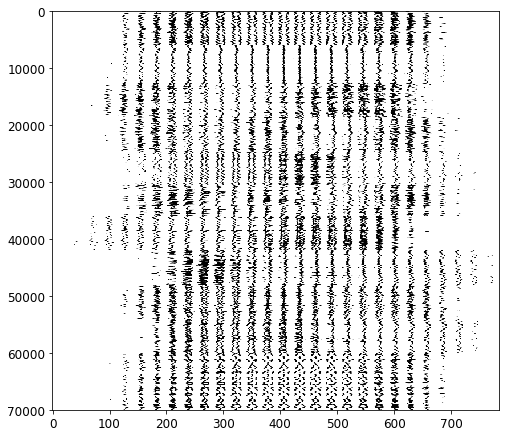

In [8]:
plt.figure(figsize=(8, 8))
plt.imshow(X, cmap=mpl.cm.binary, interpolation='nearest', aspect=.01)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

We need to reshuffle the dataset. Note the use of `np.random.permutation` for this purpose. It is simpler and faster than shuffling and index of length 60000. Note also that we only need to shuffle the training set. There is no need to shuffle the test set.

In [10]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

We use a [Stochastic Gradient Descent](https://scikit-learn.org/stable/modules/sgd.html) classifer.

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
sum(y_train_5)

5421

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
cv_score

array([0.9502 , 0.96565, 0.96495])

In the book, A. Geron creates a `Never5Classifier` class that always predicts `False`. The same result can be obtained using a `DummyClassifier` from `sklearn.dummy`. Let's see if we obtain the same results.

In [14]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
cv_score_dummy = cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

In [15]:
cv_score_dummy

array([0.90965, 0.90965, 0.90965])

As a comparison, let's create the `Never5Classifier` as shown in the book.

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never5_clf = Never5Classifier()
never5_score = cross_val_score(never5_clf, X_train, y_train_5, cv=3, scoring='accuracy')
never5_score

array([0.909  , 0.90715, 0.9128 ])

## Using the confusion matrix

To use the confusion matrix appropriately we should use `cross_val_predict` to predict the labels in the training set. Since we are using a linear classifier, in this case the difference will probably be modest. Let's check. Let's first use the naive approach where we predict the lables of the training set using a model that has used it in its entirety.

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

naive_predictions = sgd_clf.predict(X_train)
cv_predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
naive_conf_mat = confusion_matrix(y_train_5, naive_predictions)
cv_conf_mat = confusion_matrix(y_train_5, cv_predictions)

In [19]:
naive_conf_mat

array([[53470,  1109],
       [ 1003,  4418]])

In [20]:
cv_conf_mat

array([[53272,  1307],
       [ 1077,  4344]])

Even in a low-variance case like this one, we can see that the naive classifier is more optimistic than the CV one, and tends to underestimate the error in both classes.

## Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train_5, cv_predictions))
print(recall_score(y_train_5, cv_predictions))
print(f1_score(y_train_5, cv_predictions))

0.7687135020350381
0.801328168234643
0.7846820809248555


## Digression: random oversampling and SGD

This problem is fairly imbalanced, with less than 10% of the observations belonging to the "positive" class. We would like to know whether we can improve the score by combining dataset over-sampling with cross validation. I initially did the typical mistake of running cross-validation after resampling the dataset, which causes the same samples to appear in both the training and the validation folds. I have written a function (mostly copy&paste from [this Kaggle kernel](https://www.kaggle.com/lane203j/methods-and-common-mistakes-for-evaluating-models)) that, at each fold, over-samples only the training fold.

In [22]:
y_train_5_num = y_train_5.astype('int64')
y_true, y_pred = ch3.imbalanced_cross_val_predict(sgd_clf, X_train, y_train_5_num, 3)

In [23]:
print('precision = {:.3f}'.format(precision_score(y_true, y_pred)))
print('recall = {:.3f}'.format(recall_score(y_true, y_pred)))
print('F1 score = {:.3f}'.format(f1_score(y_true, y_pred)))

precision = 0.458
recall = 0.917
F1 score = 0.610


Interesting, using random-oversampling has actually improved the recall, but damaged the precision. This is very different from the impressive (but wrong) results I obtained when I first over-sampled and the cross validated. There is some more discussions about these pitfalls in this [blog post](https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation).

Note that the Scikit-Learn documentation recommends using the [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) function to compute the metric scores, rather than passing the predictions from `cross_val_predict` to the scoring function. `cross_validate` returns a more extensive information, with the train and test scores and timings. If we take the average of the F1 score for the test folds, we obtain pretty much the result above.

## Decision Function Scores

Let's plot the distribution of the `decision_function` scores from the classifier. In order to get the decision function scores for each sample we need to re-run `cross_val_predict` with the option `method='decision_function'`.

In [75]:
sgd_clf = clone(sgd_clf)
sgd_clf.fit(X_train, y_train_5)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

Let's visualize the score distribution in a histogram.

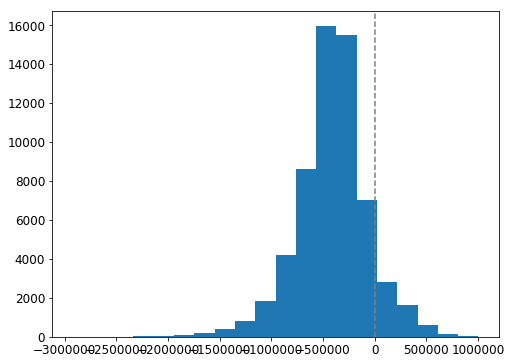

In [79]:
plt.figure(figsize=(8, 6))
_ = plt.hist(y_scores, bins=20)
plt.axvline(x=0, color='grey', linestyle='--')
plt.show()

## Precision and Recall

Let's visualize the trade-off between precision and recall.

In [30]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_train_5, y_scores)

In the first plot we show the precision and the recall as functions of the threshold.

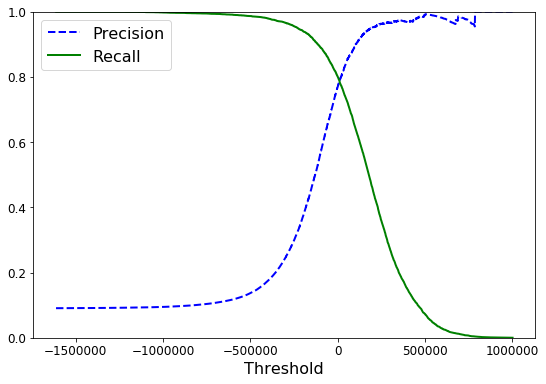

In [31]:
plt.figure(figsize=(9, 6))
ch3.plot_precision_recall_vs_threshold(prec, rec, thresh)

We can have a better idea of the precision-recall tradeoff by plotting precision as a function of recall.

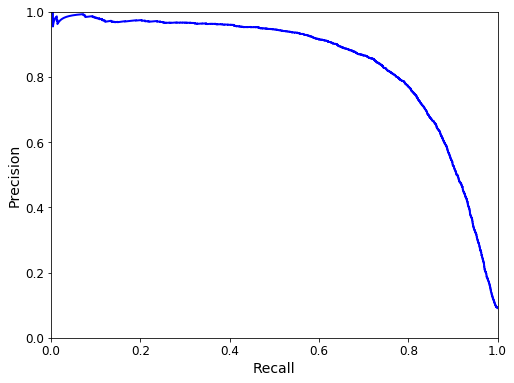

In [32]:
plt.figure(figsize=(8, 6))
ch3.plot_precision_vs_recall(prec, rec)

Does it make sense to plot the F1 score as a function of the thresholds? **TODO** in `ch3.plot_f1_scores_vs_thresholds` the F1 are one element longer than the thresholds. I have ignored the first value (it doesn't matter terribly much, I guess), but you should verify that this is correct.

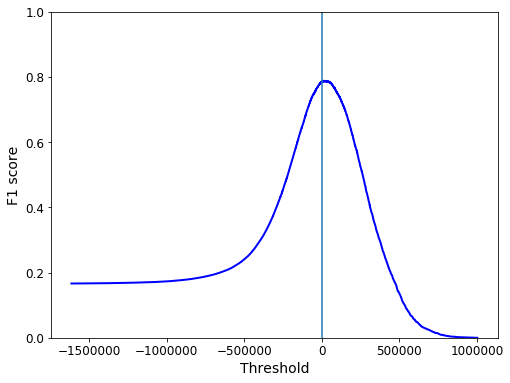

In [33]:
plt.figure(figsize=(8, 6))
ch3.plot_f1_scores_vs_thresholds(prec, rec, thresh)
plt.axvline(x=0)

The F1 score tends to favour the case when precision and recall are similar. If one is large and the other one is small, the F1 score will be small. Here the maximum is around (but, it seems, not exactly at) zero, which is the default cutoff of the SGD classifier. **THINK!** does this make sense?

## Manually choosing a value for precision or recall

Assume we want to have a precision of 90%. How can we find the threshold that will guarantee such result? From the plot above we can see that a precision of 90% roughly corresponds to a recall of 60%. In the book, Geron uses the following trick:
1. Create a logical vector based on the condition `precision >= prec_cutoff`
2. Use `argmax` to find the *first* index of the maximum value. Here the maximum value refers to the logical 
index, and it's `True`.

Let's see an example of why it works:

In [88]:
tmp = [False, False, True, False]
print('The maximum value is: {}'.format(np.max(tmp)))
print('The index of the maximum value is: {}'.format(np.argmax(tmp)))

The maximum value is: True
The index of the maximum value is: 2


Based on this idea, let's find the first index that guarantees at leat 0.9 precision.

In [89]:
threshold_90_precision = thresh[np.argmax(prec >= 0.9)]

In the `chapter3` module there is a function called `find_threshold_by_precision` that does exactly this.

In [90]:
print(threshold_90_precision)
print(ch3.find_threshold_by_precision(prec, thresh, 0.9))

103561.3878804463
103561.3878804463


Let's verify that we obtain a precision and recall in line with the plot above, when we use this cutoff.

In [91]:
y_train_pred_90 = y_scores > threshold_90_precision
print('Precision: {:.3f}'.format(precision_score(y_train_5, y_train_pred_90)))
print('Recall: {:.3f}'.format(recall_score(y_train_5, y_train_pred_90)))

Precision: 0.900
Recall: 0.640


## ROC Curve

The ROC curve plots the *True Positive Rate* vs the *False Negative Rate*, where TPR and TNR are definied as:

$$TPR = \frac{TP}{TP + FN} = recall$$

$$FPR = \frac{FP}{TN + FP} = 1 - \frac{TN}{TN + FP} = 1 - TNR = 1 - specificity$$

Remember: 
1. TPR and recall are the same.
2. TNR and specificity are the same.

To draw the ROC curve we need the TPR and the FPR. These can be obtained from the `roc_curve` function.

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, threshods = roc_curve(y_train_5, y_scores)

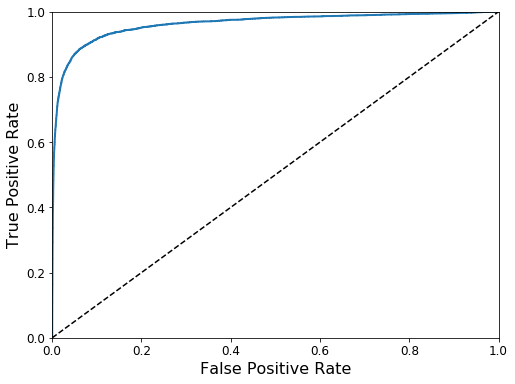

In [40]:
plt.figure(figsize=(8, 6))
ch3.plot_roc_curve(fpr, tpr)

## Area Under the Curve

Let's calculate the AUC for our model.

In [93]:
from sklearn.metrics import roc_auc_score

print('AUC = {:.3f}'.format(roc_auc_score(y_train_5, y_scores)))

AUC = 0.962


## Using a Random Forest Classifier

Random Forest classifiers do not have a `decision_function()` method, but rather a `predict_proba()` method that returns the estimated probabilities.

In [45]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

To obtain the probabilities we use `predict_proba` in the `method` argument of `cross_val_predict`.

In [48]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

/home/giovenko/miniconda3/envs/sklearn/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/giovenko/miniconda3/envs/sklearn/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/giovenko/miniconda3/envs/sklearn/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


`y_probas_forest` is a 2-column array with the probability for the 0-th class in column 0 and for class 1 in column 1.

In [95]:
y_probas_forest

array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

Our scores are the probabilities for class 1. Let's see how they are distributed.

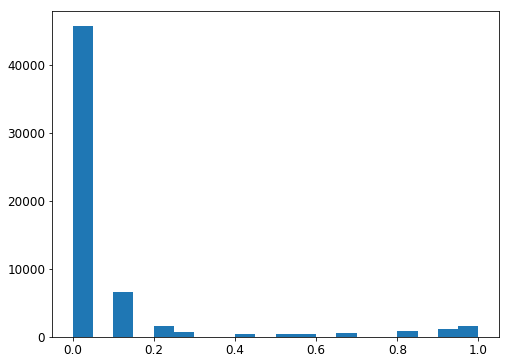

In [98]:
y_scores_forest = y_probas_forest[:, 1]
plt.figure(figsize=(8, 6))
_ = plt.hist(y_scores_forest, bins=20)

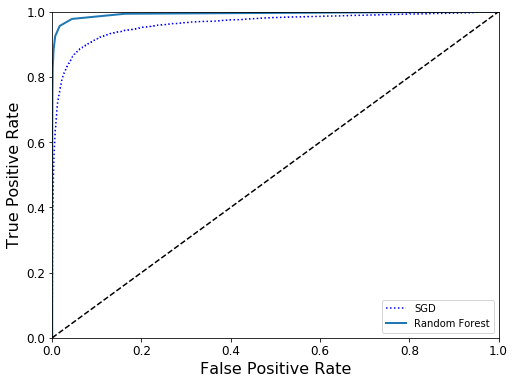

In [102]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
ch3.plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()